**SVM Python Code**

This notebook contains the SVM python code from scratch. The SVM methods you can use contain the linear SVM and the Caussian Kernel SVM. The mathmetical derivations of how to train the SVM is provided in the README.md file.

In [0]:
# Load Packages
import numpy as np
import sklearn.datasets as ds
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

The data preparation function which gives the data used to train and test the SVM.

In [0]:
# Data Preparation Function
def prepare_data(num=[1,3,5,7,9]):
    ## valid_digits is a vector containing the digits
    ## we wish to classify.
    ## Do not change anything inside of this function
    data = ds.load_digits()
    labels = data['target']
    features = data['data']
    X = features
    Y = labels
    X = X / np.repeat(np.max(X, axis=1), 64).reshape(X.shape[0], -1)
    for i in range(len(Y)):
      Y[i] = 1 if Y[i] in num else 0

    X_train, X_test, Y_train, Y_test = train_test_split(
        X, Y, test_size=0.25, random_state=10)
    Y_train = Y_train.reshape((len(Y_train), 1))
    Y_test = Y_test.reshape((len(Y_test), 1))

    return X_train, Y_train, X_test, Y_test

Load data and print the size of the training and testing dataset.

In [3]:
X_train, Y_train, X_test, Y_test = prepare_data()
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(1347, 64) (1347, 1)
(450, 64) (450, 1)


Four Functions used in SVM code.

In [0]:
# gau_kernel function calculate the Gaussian kernel value of the given numerical vectors
def gau_kernel(x, y, gamma):
    return np.prod(np.exp(-gamma * (x-y) ** 2))

In [0]:
# svm_Kernel function is used to calculate the gaussian kernel matrix
def svm_Kernel(X1,X2,gamma):
  n = X1.shape[0]
  k = X2.shape[0]
  K = np.zeros(n*k).reshape((k,n))
  
  for i in range(k):
    for j in range(n):
      K[i,j] = np.prod(gau_kernel(X1[j,:],X2[i,:],gamma))
      
  return(K)

In [0]:
# svm_predict function is used to do the prediction of SVM
# It will return the prediction accuracy and the predicted labels
def svm_predict(X,Y,alpha,kernel,K):
  
  # Read Training and Testing data
  X_train = X['train']
  X_test = X['test']
  Y_train = Y['train']
  Y_test = Y['test']
  
  # Store the length of data points
  n = len(Y_train)
  k = len(Y_test)
  
  # Two situations: Without Kernel and Gaussian Kernel
  if kernel == None:
    
    beta = np.zeros(X_train.shape[1]) # Used to store the estimated linear parameters
  
    # Sum up the supporting vectors to have the estimated linear parameters
    for i in range(n):
      beta += alpha[i]*Y_train[i]*X_train[i,:]
    
    # Make the prediction and calculate the accuracy
    f_pred = np.sign(np.matmul(X_train,beta))
    acc_train = sum(f_pred==Y_train)/len(Y_train)
    
    f_test = np.sign(np.matmul(X_test,beta))
    acc_test = sum(f_test==Y_test)/len(Y_test)
  
  elif kernel == 'Gaussian':
  
    f_pred = np.zeros(n)
    
    # Read the calculated Kernel matrices
    K_train = K['train']
    K_test = K['test']
    
    # Sum up the kernel values from the support vectos to make the prediction
    for i in range(n):
      f_pred[i] = np.sign(sum(alpha*Y_train*K_train[i,:]))
    
    # Calculate the training accuracy
    acc_train = sum(f_pred==Y_train)/len(Y_train)
  
    f_test = np.zeros(k)
  
    for i in range(k):
      f_test[i] = np.sign(sum(alpha*Y_train*K_test[i,:]))
    
    # The test accuracy
    acc_test = sum(f_test==Y_test)/len(Y_test)
    
  return(acc_train,acc_test,f_pred,f_test)
    

In [0]:
# svm function is the main function contains the training process
def svm(X_train,X_test,Y_train,Y_test,kernel=None,lamb=0.01,num_iterations=200,learning_rate=0.1):
  
  # The gamma is used for the guassian kernel
  gamma = 0.1
  
  # Length of the training dataset
  n = len(Y_train)
  
  # Transfer the training and test labels to -1 and +1
  Y_tr = np.asarray([lb[0] for lb in Y_train])
  Y_tr[Y_tr==0] = -1
  Y_t = np.asarray([lb[0] for lb in Y_test])
  Y_t[Y_t==0] = -1
  
  Q = np.zeros(n*n).reshape((n,n)) # Initialize the Q matrix
  
  # With and Without kernel way to calculate the Q matrix
  if kernel == None:
  
    for i in range(n):
      for j in range(n):
        Q[i,j] = Y_tr[i]*Y_tr[j]*np.matmul(X_train[i,:],X_train[j,:])

  elif kernel == 'Gaussian':
  
    K_train = svm_Kernel(X_train,X_train,gamma)
  
    for i in range(n):
      for j in range(n):
        Q[i,j] = Y_tr[i]*Y_tr[j]*K_train[i,j]
  
  # Store training and test dataset to two dictionaries
  X = {'train':X_train,'test':X_test}
  Y = {'train':Y_tr,'test':Y_t}

  # Calculate the Kernel matrix when kernel = 'Gaussian'
  if kernel == 'Gaussian':
    K_train = svm_Kernel(X_train,X_train,gamma)
    K_test = svm_Kernel(X_train,X_test,gamma)
    K = {'train':K_train,'test':K_test}
  else: K = None
  
  # Initialize the lists to store accuracies
  acc_train = []
  acc_test = []
  
  # Randomize the values to initialize the alpha
  alpha = np.random.uniform(0,1/lamb,n)

  # Training process: Coordinate Ascent
  for it in range(num_iterations):
  
    # Update each coordinate one by one 
    for idx in range(n):
      d_alpha = (1-np.matmul(Q[idx,:].transpose(),alpha))/Q[idx,idx]
      alpha[idx] = alpha[idx] + d_alpha*learning_rate
        
      # Maintain the restrain of alpha: alpha is from 0 to 1/lambda
      if alpha[idx] <= 0:
        alpha[idx] = 0
      elif alpha[idx] >= 1/lamb:
        alpha[idx] = 1/lamb
      
    # Every num_iterations/20 iterations, store the accuracies and print out
    if it%(num_iterations/20) == 0:
      acc_tr,acc_t,_,_ = svm_predict(X,Y,alpha,kernel,K)
      acc_train.append(acc_tr)
      acc_test.append(acc_t)
      print('At epoch %d, Training Accuracy: %f, Testing Accuracy: %f' %(it+1,acc_tr,acc_t))
      
  # Store the accuracy for the last round and make the final predictions
  acc_tr,acc_t,Y_train_pre,Y_test_pre = svm_predict(X,Y,alpha,kernel,K)
  acc_train.append(acc_tr)
  acc_test.append(acc_t)
  print('At epoch %d, Training Accuracy: %f, Testing Accuracy: %f' %(num_iterations,acc_tr,acc_t))
      
  return(acc_train,acc_test,Y_train_pre,Y_test_pre)

In [8]:
# Train Linear SVM
acc_train,acc_test,Y_train_pre,Y_test_pre = svm(X_train,X_test,Y_train,Y_test,num_iterations=1000)

At epoch 1, Training Accuracy: 0.884187, Testing Accuracy: 0.848889
At epoch 51, Training Accuracy: 0.858203, Testing Accuracy: 0.853333
At epoch 101, Training Accuracy: 0.870824, Testing Accuracy: 0.853333
At epoch 151, Training Accuracy: 0.870824, Testing Accuracy: 0.853333
At epoch 201, Training Accuracy: 0.876021, Testing Accuracy: 0.862222
At epoch 251, Training Accuracy: 0.876021, Testing Accuracy: 0.866667
At epoch 301, Training Accuracy: 0.882702, Testing Accuracy: 0.864444
At epoch 351, Training Accuracy: 0.885672, Testing Accuracy: 0.855556
At epoch 401, Training Accuracy: 0.889384, Testing Accuracy: 0.866667
At epoch 451, Training Accuracy: 0.890869, Testing Accuracy: 0.866667
At epoch 501, Training Accuracy: 0.893838, Testing Accuracy: 0.866667
At epoch 551, Training Accuracy: 0.895323, Testing Accuracy: 0.864444
At epoch 601, Training Accuracy: 0.896065, Testing Accuracy: 0.868889
At epoch 651, Training Accuracy: 0.898293, Testing Accuracy: 0.873333
At epoch 701, Training 

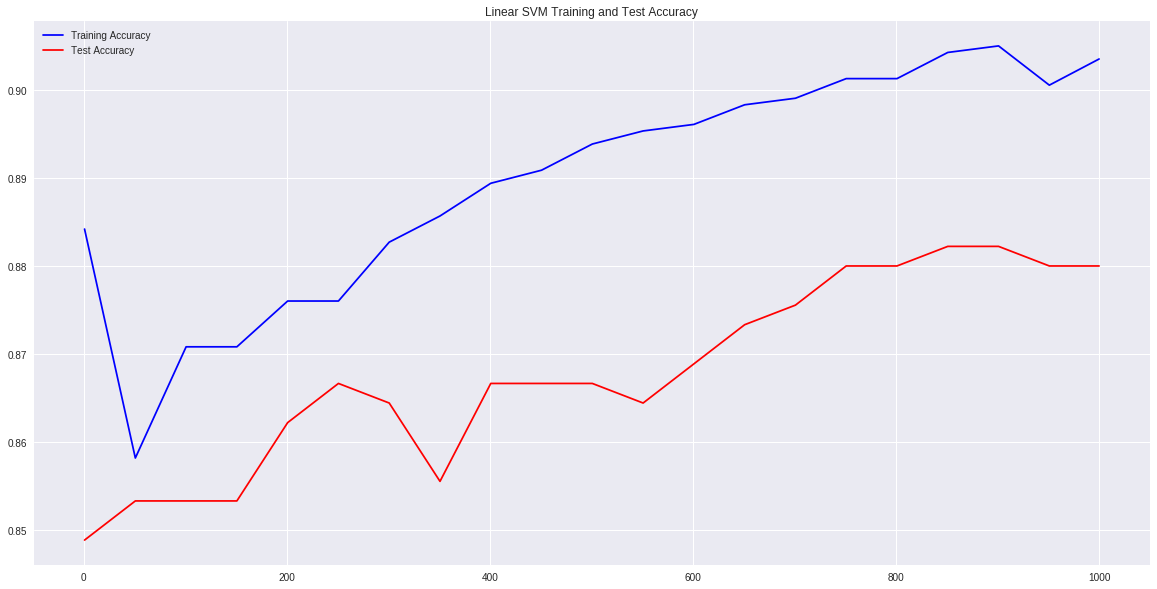

In [9]:
# Plot out the training process

ep = int(1000/(1000/20))
epochs = np.append(np.array(list(range(ep)))*(1000/20)+1,1000)

plt.figure(figsize = (20,10))
plt.plot(epochs,acc_train,'blue',label='Training Accuracy')
plt.plot(epochs,acc_test,'red',label='Test Accuracy')
plt.title('Linear SVM Training and Test Accuracy')
plt.legend()

In [10]:
# Train a gaussian kernel svm
kernel_acc_train,kernel_acc_test,kernel_Y_train_pre,kernel_Y_test_pre = svm(X_train,X_test,Y_train,Y_test,kernel='Gaussian')

At epoch 1, Training Accuracy: 0.918337, Testing Accuracy: 0.915556
At epoch 11, Training Accuracy: 0.962138, Testing Accuracy: 0.960000
At epoch 21, Training Accuracy: 0.976986, Testing Accuracy: 0.960000
At epoch 31, Training Accuracy: 0.972532, Testing Accuracy: 0.957778
At epoch 41, Training Accuracy: 0.971789, Testing Accuracy: 0.960000
At epoch 51, Training Accuracy: 0.974016, Testing Accuracy: 0.953333
At epoch 61, Training Accuracy: 0.979213, Testing Accuracy: 0.960000
At epoch 71, Training Accuracy: 0.986637, Testing Accuracy: 0.964444
At epoch 81, Training Accuracy: 0.996288, Testing Accuracy: 0.977778
At epoch 91, Training Accuracy: 0.997030, Testing Accuracy: 0.984444
At epoch 101, Training Accuracy: 0.998515, Testing Accuracy: 0.986667
At epoch 111, Training Accuracy: 1.000000, Testing Accuracy: 0.986667
At epoch 121, Training Accuracy: 1.000000, Testing Accuracy: 0.984444
At epoch 131, Training Accuracy: 1.000000, Testing Accuracy: 0.984444
At epoch 141, Training Accuracy

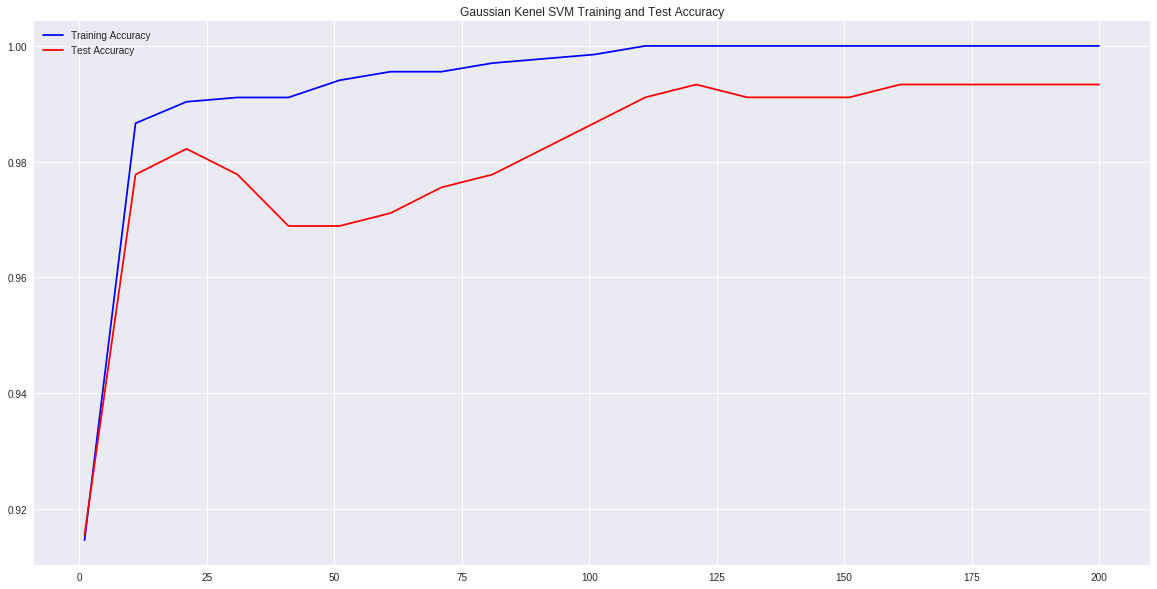

In [0]:
# Plot out the training process

ep = int(200/(200/20))
epochs = np.append(np.array(list(range(ep)))*(200/20)+1,200)

plt.figure(figsize = (20,10))
plt.plot(epochs,kernel_acc_train,'blue',label='Training Accuracy')
plt.plot(epochs,kernel_acc_test,'red',label='Test Accuracy')
plt.title('Gaussian Kenel SVM Training and Test Accuracy')
plt.legend()